<a href="https://colab.research.google.com/github/atlas-github/20190731StarMediaGroup/blob/master/3B_Estimating_the_correlation_between_two_variables_with_a_contingency_table_and_a_chi_squared_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_This is one of the 100+ free recipes of the [IPython Cookbook, Second Edition](https://ipython-books.github.io/), by [Cyrille Rossant](http://cyrille.rossant.net/), a guide to numerical computing and data science in the Jupyter Notebook. The ebook and printed book are available for purchase at [Packt Publishing](https://www.packtpub.com/big-data-and-business-intelligence/ipython-interactive-computing-and-visualization-cookbook-second-e)._

+ ▶  _[Text on GitHub](https://github.com/ipython-books/cookbook-2nd) with a [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode)_
+ ▶  _[Code on GitHub](https://github.com/ipython-books/cookbook-2nd-code) with a [MIT license](https://opensource.org/licenses/MIT)_
+ ▶  _[Go to Chapter 7 : Statistical Data Analysis](https://ipython-books.github.io/chapter-7-statistical-data-analysis/)_
+ ▶  _[Get the Jupyter notebook](https://github.com/ipython-books/cookbook-2nd-code)_

Whereas univariate methods deal with single-variable observations, multivariate methods consider observations with several features. Multivariate datasets allow the study of _relations_ between variables, more particularly their correlation, or lack thereof (that is, independence).

# A simple example first

We'll be looking at data from the census in 1994. Specifically, we are interested in the relationship between 'sex' and 'hours-per-week' worked. Click [here](https://archive.ics.uci.edu/ml/datasets/Census+Income) for the documentation and citation of the data. First let's get the assumptions out of the way:

There must be different participants in each group with no participant being in more than one group. In our case, each individual can only have one 'sex' and can not be in multiple workhour categories.
Random samples from the population. In our case, the census is a good representation of the population.

##Data exploration

For the sake of this example, we'll convert the numerical column 'hours-per-week' into a categorical column using pandas. Then we'll assign 'sex' and 'hours_per_week_categories' to a new dataframe.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
%matplotlib inline

In [83]:
cols = ['age', 'workclass', 'fnlwg', 'education', 'education-num', 'marital-status','occupation','relationship', 'race','sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names = cols)
data.head(5)

,age,workclass,fnlwg,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
#Create a column for work hour categories.
def process_hours(df):
    cut_points = [0,9,19,29,39,49,1000]
    label_names = ["0-9","10-19","20-29","30-39","40-49","50+"]
    df["hours_per_week_categories"] = pd.cut(df["hours-per-week"],
                                             cut_points,labels=label_names)
    return df

In [85]:
data = process_hours(data)
workhour_by_sex = data[['sex', 'hours_per_week_categories']]
workhour_by_sex.head()

,sex,hours_per_week_categories
0,Male,40-49
1,Male,10-19
2,Male,40-49
3,Male,40-49
4,Female,40-49


In [86]:
workhour_by_sex['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [87]:
workhour_by_sex['hours_per_week_categories'].value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

## The Null and Alternate Hypothesis

Recall that we are interested in knowing if there is a relationship between 'sex' and 'hours_per_week_categories'. In order to do so, we would have to use the Chi-squared test. But first, let's state our null hypothesis and the alternative hypothesis.

$H_0$: There is no statistically significant relationship between sex and the number of hours per week worked.

$H_1$: There is a statistically significant relationship between sex and the number of hours per week worked.

## Construct the Contingency Table

The next step is to format the data into a frequency count table. This is called a **Contingency Table**, we can accomplish this by using the pd.crosstab() function in pandas.

In [88]:
contingency_table = pd.crosstab(
    workhour_by_sex['sex'],
    workhour_by_sex['hours_per_week_categories'],
    margins = True
)
contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,6462,1246,18336,3667,458,2392,32561


Each cell in this table represents a frequency count. For example, the intersection of the 'Male' row and the '10-19' column of the table would represent the number of males who works 10-19 hours per week from our sample data set. The intersection of the 'All' row and the '50+' column would represent the total number of people who works 50+ hours a week.

##Visualize the Contingency Table with a Stacked  Bar Chart

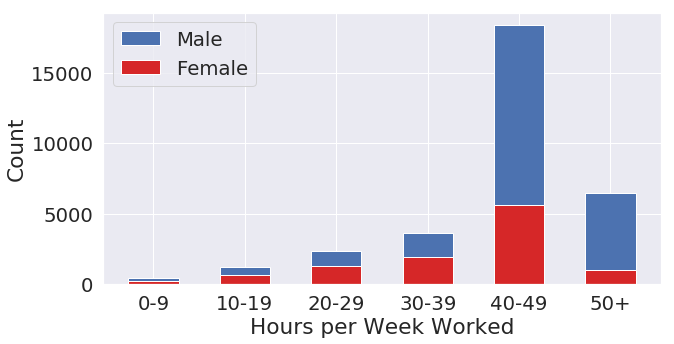

In [89]:
#Assigns the frequency values
malecount = contingency_table.iloc[0][0:6].values
femalecount = contingency_table.iloc[1][0:6].values

#Plots the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
categories = ["0-9","10-19","20-29","30-39","40-49","50+"]
p1 = plt.bar(categories, malecount, 0.55, color='#d62728')
p2 = plt.bar(categories, femalecount, 0.55, bottom=malecount)
plt.legend((p2[0], p1[0]), ('Male', 'Female'))
plt.xlabel('Hours per Week Worked')
plt.ylabel('Count')
plt.show()

The chart above visualizes our sample data from the census. If there is truly no relationship between sex and the number of hours per week worked. Then the data would show an even ratio split between 'Male' and 'Female' for each time category. For example, if 5% of the females worked 50+ hours, we would expect the same percentage for males who worked 50+ hours.

##The Chi-Squared Test for Independence - Calculation with Numpy

In order to determine whether we accept or reject the null hypothesis. We have to compute p-value similar to the other statistical tests. For testing with two categorical variables, we will use the Chi-squared test.

$\chi^2 = \frac {(observed - expected)^2}{expected}$

Where $\chi^2$ is the test statistic, $observed$ are values we have in the contingency table, $expected$ are values we would expect assuming the null hypothesis is true. Theoretically speaking, if all the expected values are equal to the observed values, then the $\chi^2$ statistic will be $0$. As a result, the null hypothesis will be retained.

First, let's put the observed values into a one dimensional array, reading the contingency table from left to right then top to bottom.

In [90]:
f_obs = np.append(contingency_table.iloc[0][0:6].values, contingency_table.iloc[1][0:6].values)
f_obs

array([  235,   671,  1287,  1914,  5636,  1028,   223,   575,  1105,
        1753, 12700,  5434])

Next, we need to calculate the expected values. The expected values assume that null hypothesis is true. We would need to calculate values if there is an equal percentage of males and females for each category. For example, this is how we would calculate the expected value for the top left cell:

Expected number of $Females$ in the $'0 - 9'$ category = $\frac{(Total number of Females * Number of People in the '0 - 9' category)}{Total number of people}$

In [91]:
row_sums = contingency_table.iloc[0:2,6].values
row_sums

array([10771, 21790])

In [92]:
col_sums = contingency_table.iloc[2,[4, 1, 5, 3, 2, 0]].values
col_sums

array([  458,  1246,  2392,  3667, 18336,  6462])

In [93]:
total = contingency_table.loc['All', 'All']

f_expected = []
for j in range(2):
    for i in col_sums:
        f_expected.append(i*row_sums[j]/total)
f_expected

[151.50388501581648,
 412.1699579251252,
 791.2604649734345,
 1213.0234636528362,
 6065.44811277295,
 2137.5941156598383,
 306.4961149841835,
 833.8300420748749,
 1600.7395350265656,
 2453.976536347164,
 12270.551887227051,
 4324.405884340162]

Now that we have all our observed and expected values, we can just plug everything into the Chi-squared test formula.

In [94]:
chi_squared_statistic = ((f_obs - f_expected)**2/f_expected).sum()
print('Chi-squared Statistic: {}'.format(chi_squared_statistic))

Chi-squared Statistic: 2287.190943926107


## Degrees of Freedom

We would have to calculate the degrees of freedom before we can determine the p-value.

$DoF = (Numberofrows - 1)*(Numberofcolumns - 1)$

In [95]:
dof = (len(row_sums)-1)*(len(col_sums)-1)
print("Degrees of Freedom: {}".format(dof))

Degrees of Freedom: 5


Now we are ready to look into the Chi-squared distribution [table](http://www.itl.nist.gov/div898/handbook/eda/section3/eda3674.htm). The cut off for a p-value of $0.05$ was $11.070$. Our $\chi^2$ statistic was so large that the p-value is approximately zero. So we have evidence against the null hypothesis.

##The Chi-Squared Test for Independence - Using Scipy

Now that we've gone through all the calculations, it is time to look for shortcuts. Scipy has a function that plugs in all the values for us. Click [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) for the documentation.

All we need to do is format the observed values into a two-dimensional array and plug it into the function.

In [96]:
f_obs = np.array([contingency_table.iloc[0][0:6].values,
                  contingency_table.iloc[1][0:6].values])
f_obs

array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

In [97]:
from scipy import stats
stats.chi2_contingency(f_obs)

(2287.190943926107,
 0.0,
 5,
 array([[  151.50388502,   412.16995793,   791.26046497,  1213.02346365,
          6065.44811277,  2137.59411566],
        [  306.49611498,   833.83004207,  1600.73953503,  2453.97653635,
         12270.55188723,  4324.40588434]]))

The results were exactly the same as our calculations with Numpy. The $\chi^2 = ~2287$, p-value $= ~0$ and degrees of freedom $= 5$.

##Conclusion

With a p-value $< 0.05$ , we can reject the null hypothesis. There is definitely some sort of relationship between 'sex' and the 'hours-per-week' column. We don't know what this relationship is, but we do know that these two variables are not independent of each other.

# How to do it...

In this recipe, we will take a look at a tennis dataset. Following a frequentist approach, we will estimate the correlation between the number of [aces](https://en.wikipedia.org/wiki/Ace_(tennis)) and the proportion of points won by a tennis player.

1. Let's import NumPy, pandas, SciPy.stats, and matplotlib:

In [0]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

2. We download and load the dataset:

In [0]:
player = 'Roger Federer'
df = pd.read_csv('https://github.com/ipython-books/'
                 'cookbook-2nd-data/blob/master/'
                 'federer.csv?raw=true',
                 parse_dates=['start date'],
                 dayfirst=True)

3. Each row corresponds to a match, and the 70 columns contain many player characteristics during that match:

In [100]:
print(f"Number of columns: {len(df.columns)}")
df[df.columns[:4]].tail()

Number of columns: 70


,year,tournament,start date,type
1174,2012,"Australian Open, Australia",2012-01-16,GS
1175,2012,"Doha, Qatar",2012-01-02,250
1176,2012,"Doha, Qatar",2012-01-02,250
1177,2012,"Doha, Qatar",2012-01-02,250
1178,2012,"Doha, Qatar",2012-01-02,250


4. Here, we only look at the proportion of points won, and the (relative) number of aces:

(0.0, 0.1629310344827586)

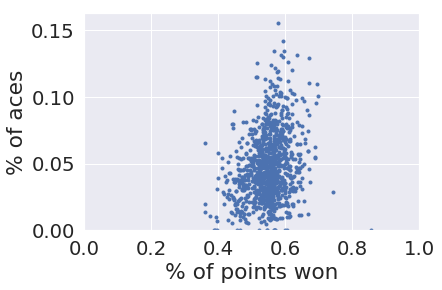

In [101]:
npoints = df['player1 total points total']
points = df['player1 total points won'] / npoints
aces = df['player1 aces'] / npoints
fig, ax = plt.subplots(1, 1)
ax.plot(points, aces, '.')
ax.set_xlabel('% of points won')
ax.set_ylabel('% of aces')
ax.set_xlim(0., 1.)
ax.set_ylim(0.)

If the two variables were independent, we would not see any trend in the cloud of points. On this plot, it is a bit hard to tell. Let's use pandas to compute a coefficient correlation.

5. For simplicity, we create a new __DataFrame__ object with only these fields. We also remove the rows where one field is missing (using __dropna()__):

In [102]:
df_bis = pd.DataFrame({'points': points,
                       'aces': aces}).dropna()
df_bis.tail()

,points,aces
1173,0.585366,0.024390
1174,0.471014,0.039855
1175,0.639535,0.046512
1176,0.606061,0.020202
1177,0.531792,0.069364


6. Let's compute the Pearson's correlation coefficient between the relative number of aces in the match, and the number of points won:

In [103]:
df_bis.corr()

,points,aces
points,1.000000,0.255457
aces,0.255457,1.000000


A correlation of ~0.26 seems to indicate a positive correlation between our two variables. In other words, the more aces in a match, the more points the player wins (which is not very surprising!).

7. Now, to determine if there is a statistically significant correlation between the variables, we use a __chi-squared test__ of the independence of variables in a __contingency table__. 
8.  First, we binarize our variables. Here, the value corresponding to the number of aces is __True__ if the player is serving more aces than usual in a match, and __False__ otherwise:

In [0]:
df_bis['result'] = (df_bis['points'] >
                    df_bis['points'].median())
df_bis['manyaces'] = (df_bis['aces'] >
                      df_bis['aces'].median())

9. Then, we create a contingency table, with the frequencies of all four possibilities (True and True, True and False, and so on):

In [105]:
pd.crosstab(df_bis['result'], df_bis['manyaces'])

manyaces,False,True
result,,
False,300,214
True,214,299


10. Finally, we compute the chi-squared test statistic and the associated p-value. The null hypothesis is the independence between the variables. SciPy implements this test in __scipy.stats.chi2_contingency()__, which returns several objects. We're interested in the second result, which is the p-value:

In [106]:
st.chi2_contingency(_)

(27.809858855369555,
 1.338423379963363e-07,
 1,
 array([[257.25024343, 256.74975657],
        [256.74975657, 256.25024343]]))

The p-value is much lower than 0.05, so we reject the null hypothesis and conclude that there is a statistically significant correlation between the proportion of aces and the proportion of points won in a match in this dataset.

Correlation does not imply causation. Here, it is likely that external factors influence both variables. See https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation for more details.

# Exercises

1. Find the $\chi^2$ value for features **income** and **education** from the **data** table (it's the first data set in this notebook) using the [.chi2_congtingency()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) function.
2. Find the correlation between **education**, **education-num**, **capital-gain**, **hours-per-week**, **income**, **fnlwg**, and **age** using the [.corr()](https://www.geeksforgeeks.org/python-pandas-dataframe-corr/) function.


In [0]:
##Start with this code
data2 = data[['education', 'education-num', 'capital-gain', 'hours-per-week', 'income', 'fnlwg', 'age']]
data2.head()

In [0]:
##INSERT CODE HERE: Build a crosstab table



In [0]:
##INSERT CODE HERE: Get the chi-square value by using the .chi2_contingency function



In [0]:
##INSERT CODE HERE: find the correlation between education-num, capital-gain, hours-per-week, income, fnlwg, and age features using the .corr() function



# How it works...

We give here a few details about the statistical concepts used in this recipe.

## Pearson's correlation coefficient

Pearson's correlation coefficient measures the linear correlation between two random variables, $X$ and $Y$. It is a normalized version of the covariance:

$$ρ=\frac{cov(X,Y)}{\sqrt {var(X)var(Y)}} = \frac{E((X−E(X))(Y−E(Y)))}{\sqrt {var(X)var(Y)}}$$

It can be estimated by substituting, in this formula, the expectancy with the sample mean, and the variance with the sample variance. More details about its inference can be found at https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient.

## Contingency table and chi-squared test 

The contingency table contains the frequencies $O_{ij}$ of all combinations of outcomes, when there are multiple random variables that can take a finite number of values. Under the null hypothesis of independence, we can compute the _expected frequencies_ $E_{ij}$, based on the marginal sums (sums in each row). The chi-squared statistic, by definition, is:

$$χ=∑_{i,j} \frac{(O_{ij}−E_{ij})^2}{E_{ij}}$$

When there are sufficiently many observations, this variable approximately follows a chi-squared distribution (the distribution of the sum of normal variables squared). Once we get the p-value, as explained in the _Getting started with statistical hypothesis testing – a simple z-test_ recipe, we can reject or accept the null hypothesis of independence. Then, we can conclude (or not) that there exists a significant correlation between the variables.

# There's more...

There are many other sorts of chi-squared tests, that is, tests where the test statistic follows a chi-squared distribution. These tests are widely used for testing the goodness-of-fit of a distribution, or testing the independence of variables. More information can be found in the following pages:

+ Chi2 test in SciPy documentation available at http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html
+ Contingency table introduced at https://en.wikipedia.org/wiki/Contingency_table
+ Chi-squared test introduced at https://en.wikipedia.org/wiki/Pearson's_chi-squared_test